In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math
from astroNN.nn.layers import MCDropout
import math
from matplotlib.ticker import FormatStrFormatter
# plt.rcParams['axes.grid'] = True
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'

In [2]:

syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov), np.min(np.abs(syscov)))

-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31) 1.695011341e-07


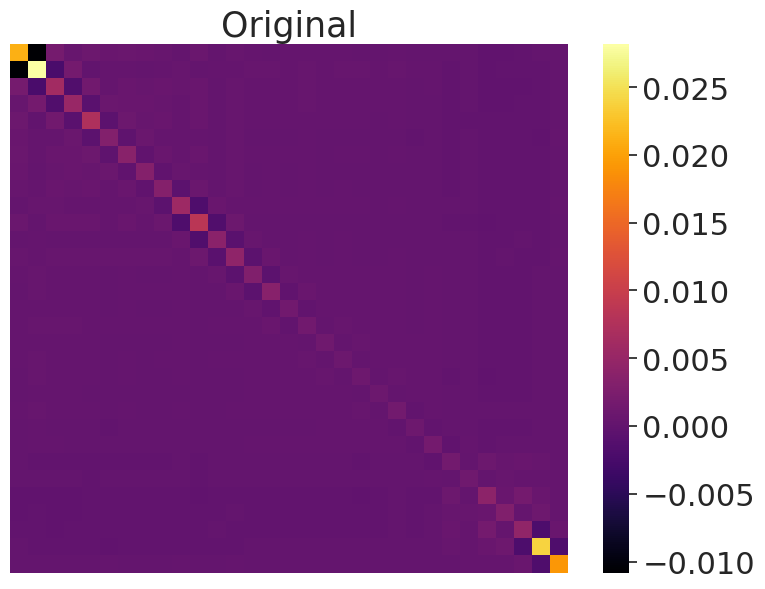

In [3]:
plt.figure(figsize=(9, 7), dpi=100)
sns.set(font_scale=2)
sns.heatmap(syscov, 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original', fontsize=25)
plt.savefig('originalcov.png')

Text(0.5, 1.0, 'Original')

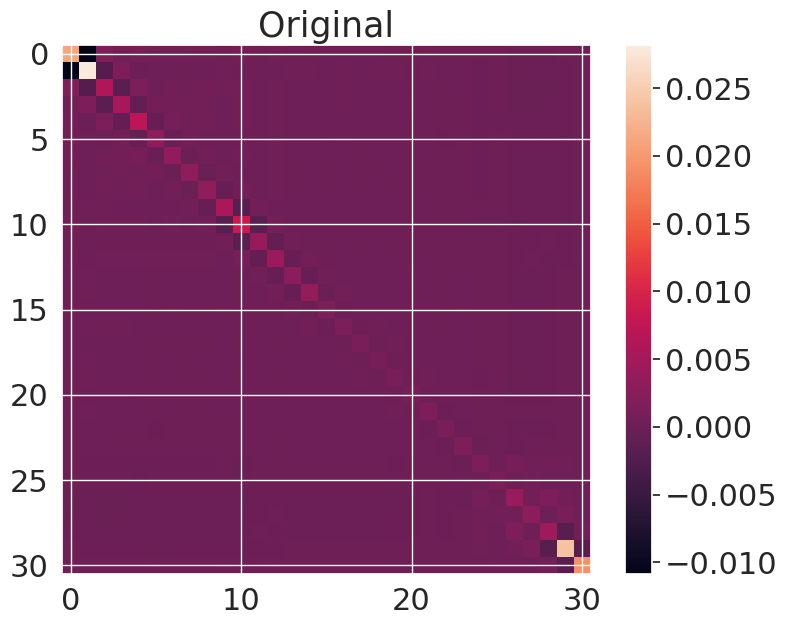

In [4]:
plt.figure(figsize=(9, 7), dpi=100)
plt.imshow(syscov)
plt.colorbar()
plt.title('Original', fontsize=25)


In [5]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [6]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = 10**orderMag(matrix[row, col])
    return magMatrix

def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) > np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix           
            

In [7]:
def matrixGenerator(omatrix, nmatrix, noise_factor=0.1):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        print("Generating matrix {}".format(it+1), end='\r')
        mag = matrixMag(omatrix)
        m = omatrix + np.multiply(noise_factor*np.random.randn(nsize,nsize), mag)       
        matrixset[it, :, :] = m
        
    return matrixset

def matrixGenerator2(omatrix, nmatrix, freq_original=100):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        print("Generating matrix {}".format(it+1), end='\r')
        if it % freq_original ==0:
            m = omatrix
        else:
            m = P@omatrix@P.T
       
        mag = matrixMag(omatrix)
        
        m += np.multiply(0.1*np.random.rand(nsize,nsize), mag)
        matrixset[it, :, :] = m
        

    return matrixset

### Generate a data set with covariance matrix from the original plus gaussian noise

In [8]:
numMatrix = 2000
# covset, D = matrixGenerator3(syscov, numMatrix)
covset = matrixGenerator(syscov, numMatrix, noise_factor=0.1)
# covset_noise = matrixGenerator(syscov, numMatrix, noise_factor=10)

(2000, 31, 31) 1.3277810983025076e-07


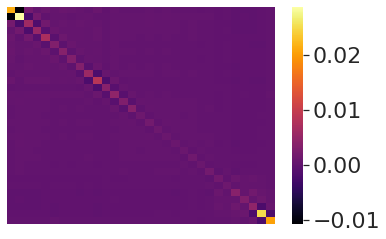

In [9]:
print(np.shape(covset), np.min(np.abs(covset)))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
# covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(covset_test[8,:,:], 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
# covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
# covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



## Here starts the VAE network

- Original input is the data len for JLA compilation-
- We try with 3 hidden layer
- We want that the latent space has 1 dimension to make a mapping with the redshift

In [10]:
# [100,100,100,50] 150 epochs -5*1e-12 weight factrr KL

original_dim = nsize*nsize
intermediate_dim1 = 200
intermediate_dim2 = 100
intermediate_dim3 = 50
latent_dim = 1
actfn = 'tanh'


inputs = tf.keras.Input(shape=(original_dim))
h = layers.Dense(intermediate_dim1, activation=actfn)(inputs)
h = layers.Dense(intermediate_dim2, activation=actfn)(h)
h = layers.Dense(intermediate_dim3, activation=actfn)(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0, stddev=0.05)
                              #                               mean=0.0, stddev=0.05)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [12]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])
# z = Sampling()([z_mean, z_log_sigma])
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 961)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          192400      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          20100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           5050        dense_1[0][0]                    
____________________________________________________________________________________________

In [13]:
# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim3, activation=actfn)(latent_inputs)
x = layers.Dense(intermediate_dim2, activation=actfn)(x)
x = layers.Dense(intermediate_dim1, activation=actfn)(x)
outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')


In [14]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5*1e-3
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
vae_train = vae.fit(covset_train, covset_train,
                    epochs=50,
                    batch_size=32)
#                     shuffle=True,
#                     validation_data=(covset_test, covset_test))

Epoch 1/50
50/50 [==============================] - 0s 2ms/step - loss: 9.9045e-06
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 2.7943e-07
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 1.1848e-07
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 5.4440e-08
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 3.0869e-08
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 2.0207e-08
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 1.6552e-08
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 1.2987e-08
Epoch 9/50
50/50 [==============================] - 0s 2ms/step - loss: 1.0460e-08
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 9.1491e-09
Epoch 11/50
50/50 [==============================] - 0s 2ms/step - loss: 8.7831e-09
Epoch 12/50
50/50 [==============================] - 0s 2ms/step - loss: 8.4578e-09
E

In [16]:
# Guardar modelos

# encoder.save('../models/vaeffnn_encoder.h5', save_format="tf")
# decoder.save('../models/vaeffnn_decoder.h5', save_format="tf")
# encoder.save_weights('../models/weights_encoder.h5')
# decoder.save_weights('../models/weights_decoder.h5')


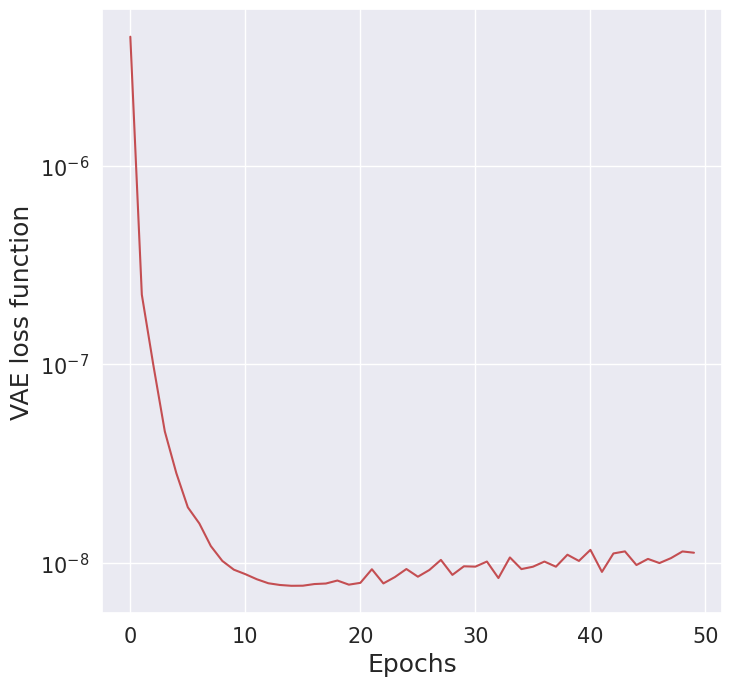

In [17]:
plt.figure(figsize=(8, 8), dpi=100)
plt.yscale('log')
plt.plot(vae_train.history['loss'], color='r')
# plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('VAE loss function', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_vae.png')

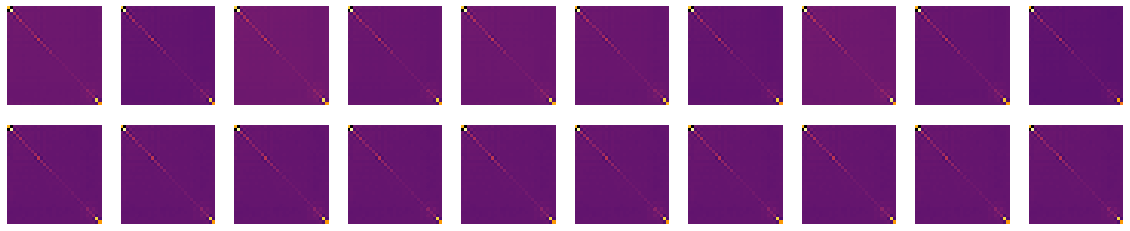

In [18]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs[2])

n = 10  # How many figures we will display
items = [np.random.randint(len(covset_test)) for i in range(n)]
plt.figure(figsize=(20, 4))
for i, it in enumerate(items):
    # Display original
    ax = plt.subplot(2, n, i + 1)
   
    sns.heatmap(covset_test[it].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[it].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

In [19]:
x_test_encoded = encoder.predict(covset_test)
z_mean = x_test_encoded[0]
z_std = x_test_encoded[1]
z_latent = x_test_encoded[2]

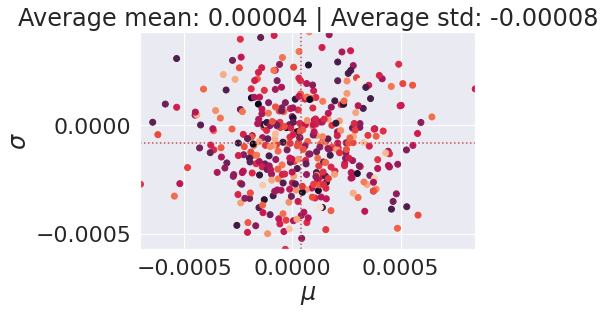

In [20]:
xmin = np.min(z_mean)#-0.1*10**orderMag(meanmean)
xmax = np.max(z_mean)#+0.1*10**orderMag(meanmean)
ymin = np.min(z_std)#-0.1*10**orderMag(meanmean)
ymax = np.max(z_std)#+0.1*10**orderMag(meanmean)
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)

# plt.figure(figsize=(6,6), dpi=100)
plt.scatter(z_mean, z_std, c=z_latent)
plt.title('Average mean: {:.5f} | Average std: {:.5f}'.format(meanmean, meanstd))

plt.hlines(meanstd, xmin, xmax, colors='r', linestyles='dotted')
plt.vlines(meanmean, ymin, ymax, colors='r', linestyles='dotted')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.colorbar()
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.savefig('sigma_mean_latent.png')

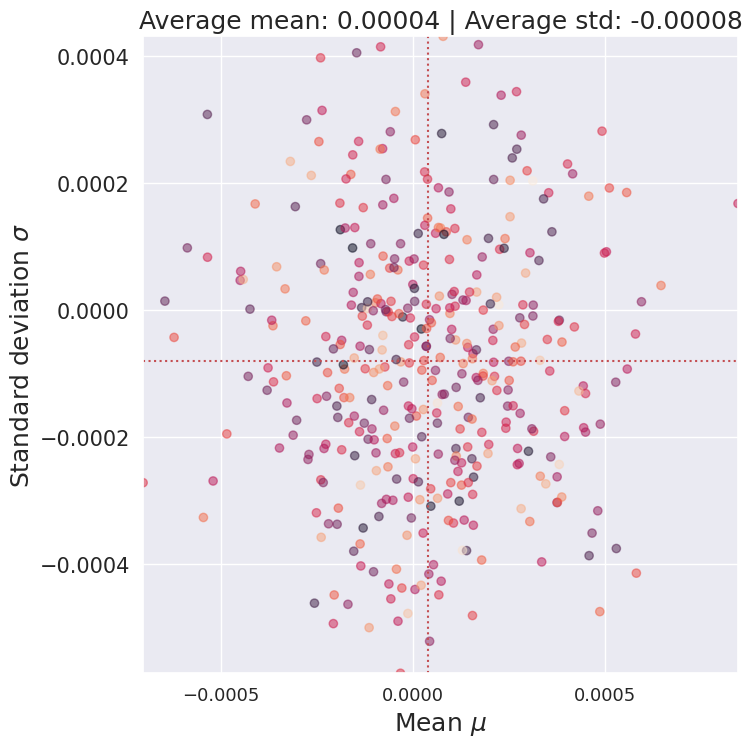

In [21]:
plt.figure(figsize=(8,8), dpi=100)
# fig, ax = plt.subplots()

# ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.scatter(z_mean, z_std, marker='o', c=z_latent, alpha=0.5)
plt.xlabel('Mean $\mu$', fontsize=18)
plt.ylabel('Standard deviation $\sigma$', fontsize=18)
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)
plt.title('Average mean: {:.5f} | Average std: {:.5f}'.format(meanmean, meanstd), fontsize=18)

# ax.xaxis.set_ticks(np.arange(xmin, xmax, 1e-10))
# plt.colorbar()

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.hlines(meanstd, xmin, xmax, colors='r', linestyles='dotted')
plt.vlines(meanmean, ymin, ymax, colors='r', linestyles='dotted')
plt.tight_layout()
plt.savefig('mean_sigma_latent.png', transparent=True)

# plt.show()

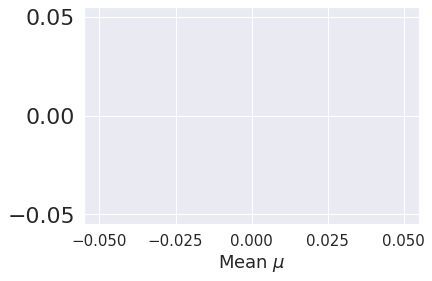

In [39]:
# plt.figure(figsize=(8,8), dpi=100)

# x = np.linspace(-0.5*1e-4, 1*1e-4, 100)

x = np.linspace(meanmean+3*meanstd, meanmean-3*meanstd, 100)
y = sp.stats.norm.pdf(x, meanmean, meanstd)

# plt.vlines(meanmean, 0, 16000, colors='r', linestyles='dotted')
plt.xlabel('Mean $\mu$', fontsize=18)
# plt.yticks([])
plt.xticks(fontsize=15)
plt.plot(x, y)
# plt.grid(None) 

# plt.rcParams['figure.facecolor'] = 'white'

# sns.displot(z_latent, kind='kde', legend=False, )
# plt.savefig('latent_dist.png', transparent=True)

In [27]:
clean_matrix = vae.predict(covset_test[80,:].reshape(-1,31*31))

<AxesSubplot:>

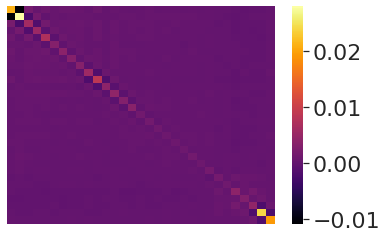

In [28]:
sns.heatmap(clean_matrix.reshape(31,31), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

# Test with syscov

In [29]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
# z_sample_syscov, mean_latent
z_mean_syscov, z_std_syscov, z_sample_syscov

(array([[4.0732295e-05]], dtype=float32),
 array([[-7.3221745e-05]], dtype=float32),
 array([[0.00911111]], dtype=float32))

<AxesSubplot:>

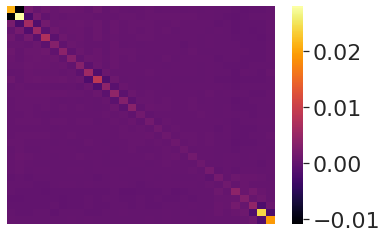

In [30]:
vec = np.array(z_sample_syscov)
decm = decoder.predict(vec)
sns.heatmap(decm.reshape(31,31), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', cbar=True,
            robust=False)

# Loading FFNN predictions

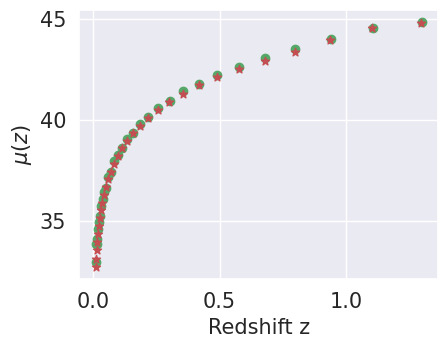

In [31]:
data = np.loadtxt("fake_binned_JLA2TEST3new.dat")
ranz = data[:,0]
dlfake = data[:,1]
plt.figure(figsize=(5,4), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(ranz, dlfake, c='r', label='Synthetic data', marker='*')


# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

In [32]:
# pred_dl
mean_ref = np.mean(dist)
std_ref = np.std(dist)
mean_pred = np.mean(dlfake)
std_pred = np.std(dlfake)
# delta_mean = z_mean_syscov - mean_ref
delta_mean = z_sample_syscov - mean_ref


mean_ref, delta_mean, z_mean_syscov

(38.762822546580644,
 array([[-38.75371]], dtype=float32),
 array([[4.0732295e-05]], dtype=float32))

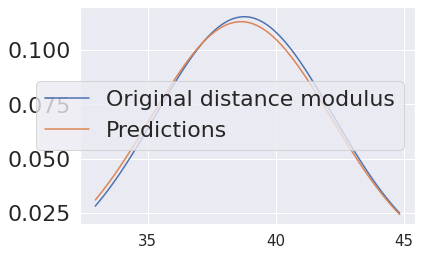

In [40]:
xmin = np.min(dist)
xmax= np.max(dist)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)


# x = np.linspace(xmin, xmax, 100)
y2 = sp.stats.norm.pdf(x, mean_pred, std_pred)
plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions')
plt.xticks(fontsize=15)

# plt.show()
# dist_sc
plt.legend()

<AxesSubplot:>

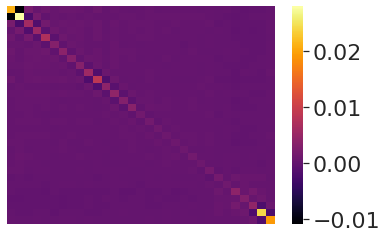

In [41]:
z_sample = np.array([mean_pred+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")


# Now with FFNN+MC-DO predictions

In [42]:
data = np.loadtxt("fake_binned_JLADO.dat")
ranz = data[:,0]
pred_dl = data[:,1]


# fake_data = np.stack((ranz[index], pred_dl[index].reshape(31,)), axis=1)
# np.savetxt("fake_binned_JLADO.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')


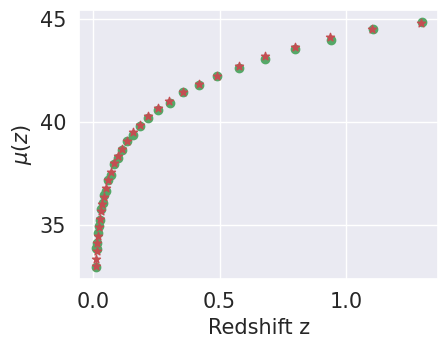

In [43]:
plt.figure(figsize=(5,4), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(ranz, pred_dl, c='r', label='Synthetic data', marker='*')


# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

In [44]:
# pred_dl
mean_pred_do = np.mean(pred_dl)
std_pred_do = np.std(pred_dl)


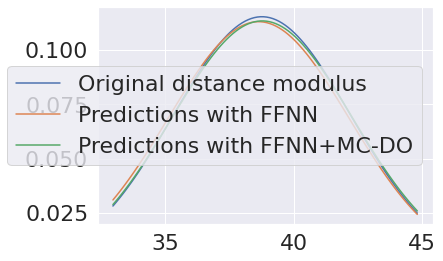

In [46]:
xmin = np.min(pred_dl)
xmax= np.max(pred_dl)
# x = np.linspace(xmin, xmax, 100)
# y3 = sp.stats.norm.pdf(x, mean_ref, std_ref)


# x = np.linspace(xmin, xmax, 100)
y3 = sp.stats.norm.pdf(x, mean_pred_do, std_pred_do)
plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions with FFNN')
plt.plot(x, y3, label='Predictions with FFNN+MC-DO')

# plt.show()
# dist_sc
plt.legend()

<AxesSubplot:>

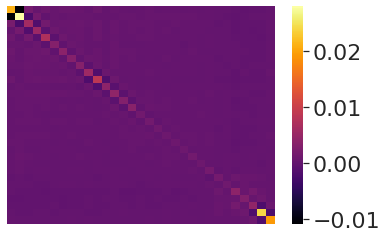

In [47]:
z_sample = np.array([mean_pred_do+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# np.savetxt("fake_binned_JLA_COVdecodedTESTDO.dat", newmatrixr, delimiter= " ", header="#fake COV")


# Interpolating a redshift

In [48]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5') 
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})

zpoints = np.copy(ranz)
zpoints[27] += 0.05

In [49]:
pred_random = ffnn.predict(np.log(zpoints))
dlfake = scalerdist.inverse_transform(pred_random[:,0].reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLA_interpoint.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

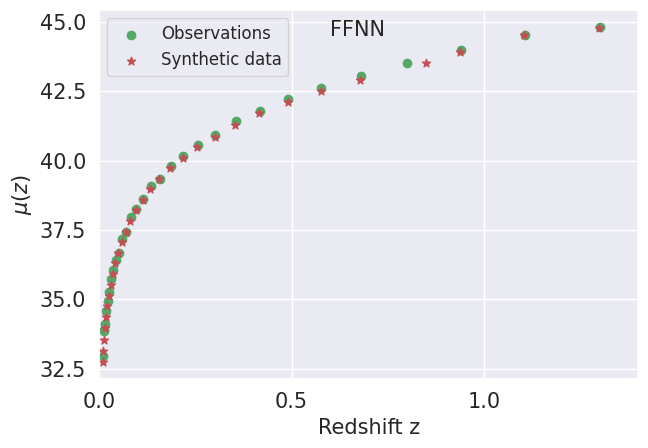

In [50]:
plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake, c='r', label='Synthetic data', marker='*')


plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)
# plt.savefig('JLA_FFNN.png')

In [51]:
# pred_dl
mean_pred_interpoint = np.mean(dlfake)
std_pred_interpoint = np.std(dlfake)

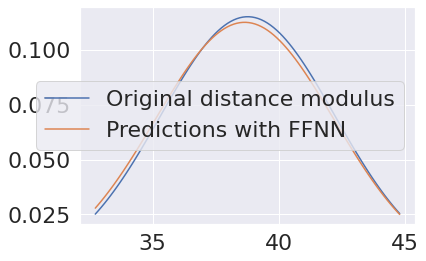

In [52]:
xmin = np.min(dlfake)
xmax= np.max(dlfake)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)

plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions with FFNN')

# plt.show()
# dist_sc
plt.legend()


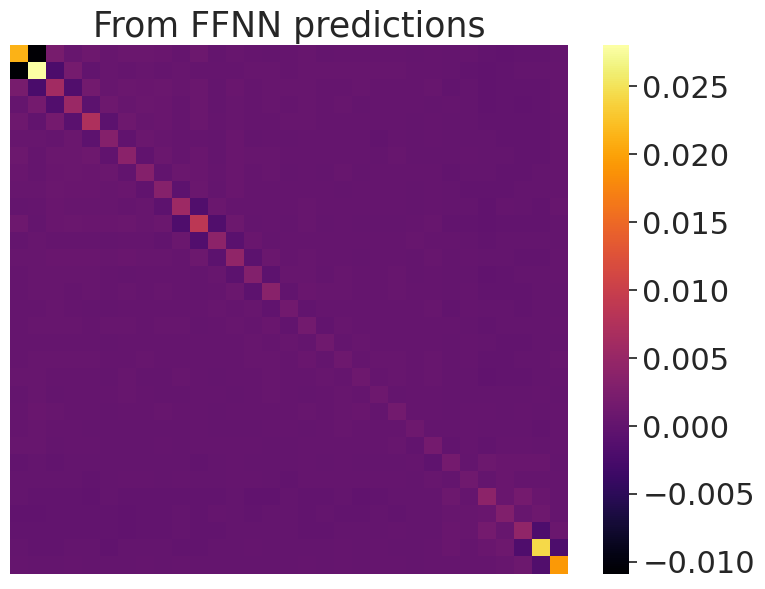

In [64]:
z_sample = np.array([mean_pred_interpoint+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

plt.figure(figsize=(9, 7), dpi=100)
sns.set(font_scale=2)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVdecodedVAEinterpoint.dat", newmatrixr, delimiter= " ", header="#fake COV")
plt.title('From FFNN predictions',fontsize=25)
plt.savefig('vae_cov_ffnn.png')


## The same with FFNN-MC-DO

In [54]:
pred_random = ffnn_do.predict(np.log(zpoints))
dlfake_do = pred_random[:,0].reshape(-1,1)
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake_do.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLA_interpoint_DO.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

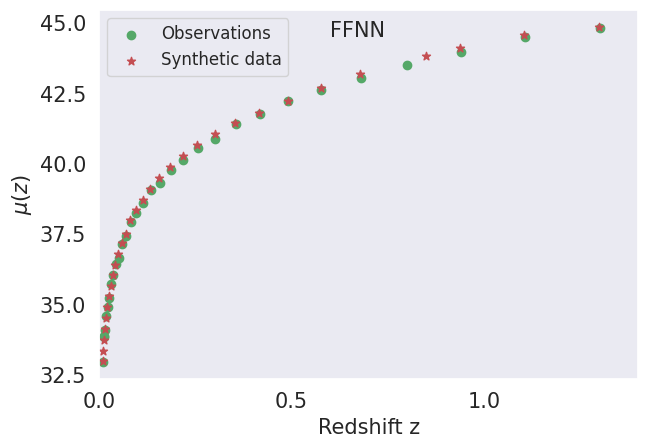

In [55]:
plt.figure(figsize=(7, 5), dpi=100)
# plt.axis('off')
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake_do, c='r', label='Synthetic data', marker='*')


plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.grid()
plt.legend(fontsize=12)

In [56]:
# pred_dl
mean_pred_interpoint_DO = np.mean(dlfake_do)
std_pred_interpoint_DO = np.std(dlfake_do)

Text(0.5, 0, 'Modulus distance $\\mu (z)$')

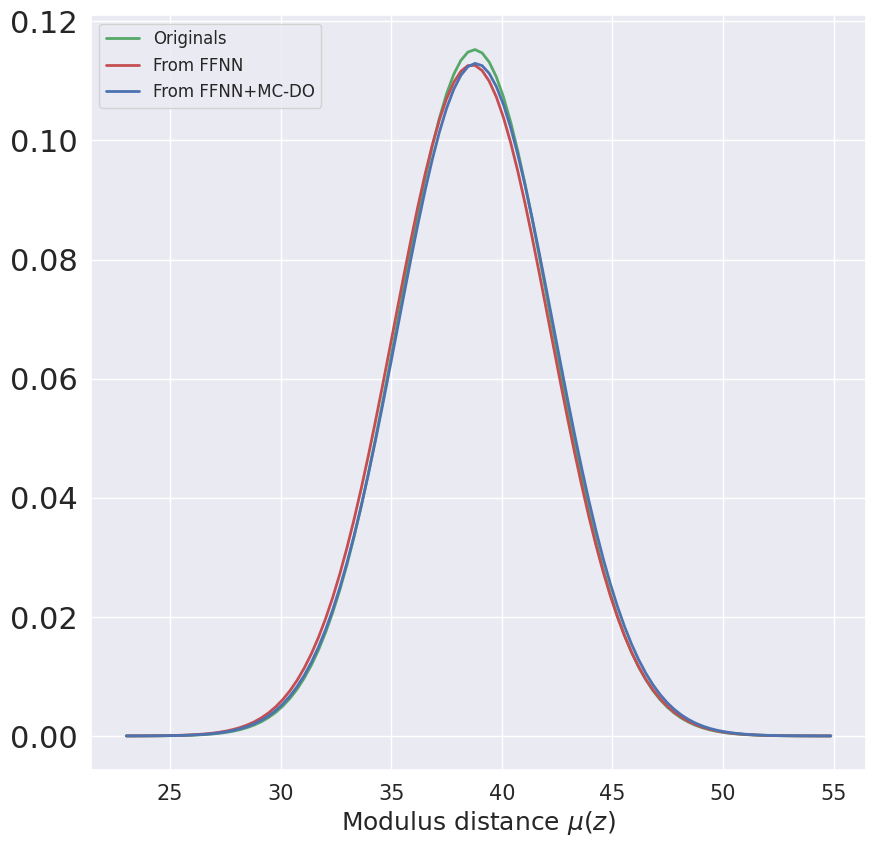

In [57]:
plt.figure(figsize=(10, 10), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin-10, xmax+10, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='g', linewidth=2)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=2)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=2)

plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
plt.legend(fontsize=12, loc='upper left')
# plt.yticks([])
plt.xticks(fontsize=15)

plt.xlabel("Modulus distance $\mu (z)$", fontsize=18)
# plt.savefig('modulus_dist_gauss.png', transparent=True)

No handles with labels found to put in legend.


(array([30., 35., 40., 45., 50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

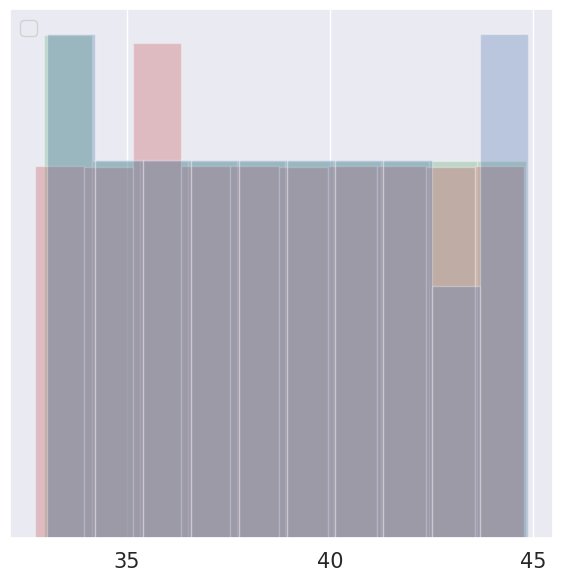

In [58]:
plt.figure(figsize=(7, 7), dpi=100)

plt.hist(dist, density=True, alpha=0.3, color='g')
plt.hist(dlfake, density=True, alpha=0.3, color='r')
plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# dist_sc
plt.legend(fontsize=15)
plt.yticks([])
plt.xticks(fontsize=15)

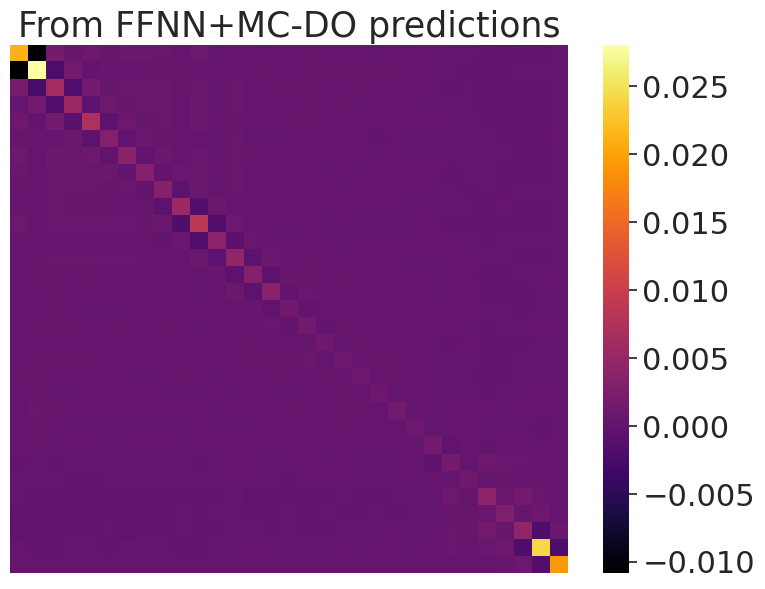

In [63]:
z_sample = np.array([mean_pred_interpoint_DO+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)


plt.figure(figsize=(9, 7), dpi=100)
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVdecodedVAEinterpoint_DO.dat", newmatrixr, delimiter= " ", header="#fake COV")
plt.title('From FFNN+MC-DO predictions', fontsize=25)
plt.savefig('vae_cov_ffnn_do.png')

In [ ]:
# sns.histplot(np.array([dist.reshape(31,), dlfake.reshape(31,), dlfake_do.reshape(31,)]))
plt.hist(dist, alpha=0.4)
plt.hist(dlfake, alpha=0.4)
plt.hist(dlfake_do, alpha=0.4)
# plt.yscale('log')

In [ ]:
plt.figure(figsize=(8, 8), dpi=100)

sns.distplot(dist, color='r', label='Original')
sns.distplot(dlfake, color='g', label='FFNN')
sns.distplot(dlfake_do, color='y', label='FFNN+MC-DO')
plt.xlabel('$\mu$')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
# plt.savefig('modulusjlahist.png')